# Реализация слабой локализации с помощью скользящего окна 
В этом уроке мы разберёмся с практической реализацией алгоритма скользящего окна. Будем решать довольно простую "игрушечную" задачу по локализации рукописных цифр. Для решения нам понадобится обученный классификатор, в качестве которого мы будем использовать свёрточную нейронную сеть. 

Обучать классификатор будем на датасете MNIST, в котором как раз представлены рукописные цифры (10 классов).

Для тестироания локализации нам понадобится синтезировать входную картинку следующим образом: будем брать холст бОльшего размера (с чёрным фоном) и случайно размещать на нём несколько цифр из тестовой подвыборки MNIST. И нашей задачей будет найти (локализовать) цифры, соответствующие разным классам. Ответом на такую задачу будут являться тепловые карты, которые нам надо будет построить с помощью классификатора, "пробегающего" по входному изображению в режиме скользящего окна.

В тех местах входного изображения, где нет никаких цифр, наш классификатор должен выдавать ответ "фон". То есть нам надо будет добавить 11-й класс. Так как фон у нас просто черный (нули в пикселях), именно такие картинки мы и возьмем в качестве обучающих образцов для этого класса. Размер таких картинок должен быть таким же, как и у остальных образцов из MNIST (28x28).

Однако, для более качественной работы подхода скользящего окна нам также потребуется добавить дополнительные обучающие образцы для нашего классификатора. С текущими образцами (цифры и фон) классификатор будет работать уверенно, если цифра полностью попала в окно (и находится в середине окна) или если в окно попал только фон (всё чёрное). Но что делать классификатору, если в окно попала лишь часть (кусок) цифры? Без нашей помощи он может работать непредсказуемо. Для этого нам надо добавить в выборку образцы цифр с небольшими смещениями (цифра не строго по центру) и трактовать эти образцы, как принадлежащие к тому или иному классу "цифра". Кроме того, добавим образцы, где входит лишь кусочек цифры и будем трактовать их как класс "фон" (отсутствие цифры). Всё это позволит увидеть более качественные "пятна" слабой локализации на тепловых картах.

### Загрузка необходимых библиотек
Здесь мы загружаем различные библиотеки, включая TensoFlow.

В TensorFlow инициируем режим жадного (eager) выполнения и проверяем версию (должна быть 1.14)

In [1]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.5.0


# Подготовка датасета

### Загрузка оригинального датасета MNIST
Загружаем датасет MNIST (train и test) и приводим данные к удобному формату:
* Размер: (N, 28, 28, 1), где N - количество образцов в подвыборке
* Значения интенсивности: float32 в диапазоне [0, 1]

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11493376/11490434 [==============================] - 0s 0us/step


### Визуализация нескольких образцов из MNIST
Визуализируем несколько образцов из оригинального датасета MNIST

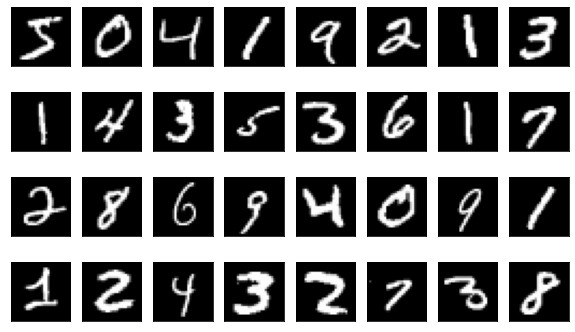

In [3]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_some_samples(train_x[:32, ...])

### Аугментация: добавление образцов класса "фон"
Для задач локализации нам необходимо добавить дополнительный класс "фон", который обозначает "отсутствие цифры". Индекс этого 11-го класса будет "10" (так как классы нумеруются с нуля).

Однако, недостаточно просто взять черную картинку и использовать её как образец "фона". Если в скользящее окно попадает небольшой кусочек цифры, это тоже должно означать "отсутствие цифры".

Сгенерируем соответствующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [25%, 75%].

Так как при таком подходе у нас будут автоматически получаться абсолютно чёрные картинки (где цифра после сдвига ушла за пределы картинки), нам не нужно отдельно генерировать чисто чёрные картинки для класса "фон".

Затем визуализируем несколько образцов.

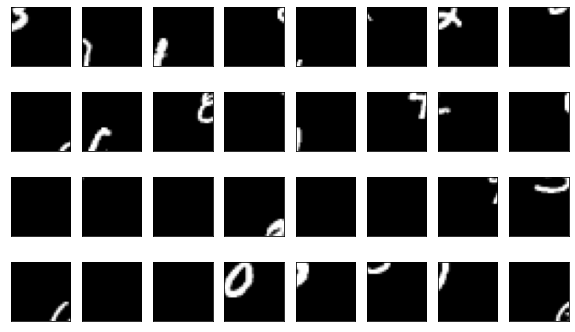

In [4]:
bg_samples = 100000 # Количество обучающих образцов из класса "фон"

bg_train_x = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
bg_train_y = np.ones((bg_samples,), dtype=np.int32)*10 

src_idxs = random.choices(range(train_x.shape[0]), k=bg_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    bg_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(bg_train_x[:32, ...])

### Аугментация: добавление образцов исходных классов цифр
Для более наглядной локализации необходимо также добавить образцы с незначительными смещениями. 
Если цифра не строго по центру, но всё равно попала в окно, значит это окно надо классифицировать как цифру.

Сгенерируем соответствующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [0, 25%].

Затем визуализируем несколько образцов.

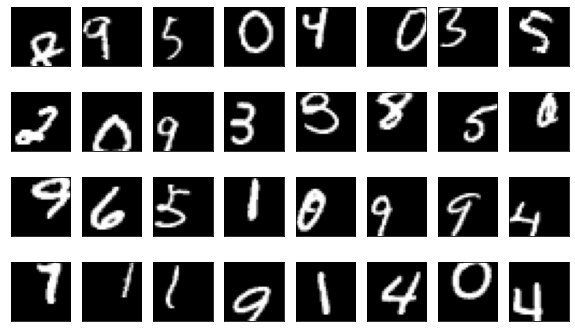

In [5]:
sh_samples = 50000 # Количество дополнительно сгенерированных образов для цифр (со смещениями)

sh_train_x = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
sh_train_y = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(train_x.shape[0]), sh_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    sh_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    sh_train_y[i] = train_y[src_idxs[i]]

plot_some_samples(sh_train_x[:32, ...])

### Объединение исходного датасета MNSIT и двух новых сгенерированных
Получаем финальные train и test датасеты, содержащие исходные и новые сгенерированные данные (конкатенируем всё по нулевому измерению)

In [6]:
train_x = np.concatenate((train_x, bg_train_x, sh_train_x), axis=0)
train_y = np.concatenate((train_y, bg_train_y, sh_train_y), axis=0)

# Обучение классификатора

Для начала нам необходимо обучить обычный классификатор для распознавания цифр, но на нашем новом аугментированном датасете с классом "фон". Далее мы будем применять этот классификатор для задачи слабой локализации.

### Параметры обучения

In [7]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

### Классификационная модель
Это наш классификатор на основе CNN. На выходе 11 классов.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

### Подготовка модели к обучению

In [9]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

### Обучение модели

In [10]:
model.fit(train_x, train_y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
3282/3282 [==============================] - 44s 4ms/step - loss: 0.1157 - accuracy: 0.9644
Epoch 2/3
3282/3282 [==============================] - 12s 4ms/step - loss: 0.0416 - accuracy: 0.9866
Epoch 3/3
3282/3282 [==============================] - 12s 4ms/step - loss: 0.0284 - accuracy: 0.9903


### Оценка качества классификационной модели

In [11]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 2ms/step - loss: 0.0296 - accuracy: 0.9905


[0.029608145356178284, 0.9904999732971191]

# Слабая локализация с помощью скользящего окна
Теперь у нас есть обученный классификатор, который мы можем применить для решения задачи слабой локализации.

Для начала сгенерируем тестовое изображение для задачи локализации, а затем применим для него подход скользящего окна (построим тепловые карты).

Чтобы построить тепловые карты, нам необходимо применить классификатор для различных участков входного изображения (в режиме скользящего окна) и записать ответ (распределение вероятностей) в соответствующий пиксель тензора тепловых карт

### Получение входного изображения для локализации

Можно сгенерировать случайное изображение с несколькими случайными цифрами из тестового множества

А можно загрузить готовое изображение digits.png

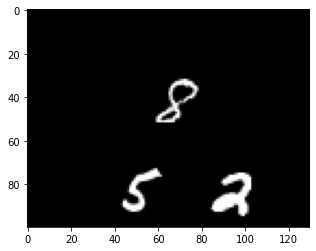

In [12]:
if True: # Сгенерировать случайное изображение
    
    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = test_x[random.randint(0, test_x.shape[0])]
        img = add_digit(img, digit)
    
else: # Загрузить готовое изображение 'digits.png'
    
    INPUT_IMAGE_FPTAH = 'digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)
    
# Превращение входной картинки в RGB 
# (для визуализации и последующего смешивания с цветной тепловой картой)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

### Подготовка буфера для тепловых карт
Буфер тепловых карт будет являться трёхмерным тензором. Первые два измерения - пространственные, третье измерение - ответственно за классы, который у нас 11. Другими словами у нас есть 11 двумерных тепловых карт, ответственных за каждый отдельный класс. Значения в тепловой карте будут в диапазоне [0, 1], что означает вероятность принадлежности данного пикселя к тому или иному классу. Эти вероятности мы будем брать из выхода классификатора.

Пространственные размерности тепловых карт будут меньше, чем входное изображение. Они будут соответствовать тому, сколько раз можно "уложить" скользящее окно во входном изображении (от края до края).

**[ЗАДАНИЕ 1]** Разберитесь, почему размеры тепловых карт именно такие, как в коде ниже.

In [13]:
inp_shape = (train_x.shape[1], train_x.shape[2]) # размер входа для классификатора

heatmaps = np.zeros((
    img.shape[0] - inp_shape[0] + 1,
    img.shape[1] - inp_shape[1] + 1,
    NUM_CLASSES))

### Пример применения классификатора
В этом примере кода мы берем кусочек входной картинки (размером 28x28) из левого верхнего угла, подаём его в классификатор, получаем вектор распределения вероятностей и записываем этот вектор в соответствующую позицию в тепловых картах

Кроме того, здесь используется магическая функция `%%time`, которая замеряет время работы данной ячейки

In [14]:
%%time

window = img[0:inp_shape[0], 0:inp_shape[1], :]
pred = model.predict(window[None, ...])[0, ...]
heatmaps[0, 0, :] = pred

CPU times: user 139 ms, sys: 3.34 ms, total: 142 ms
Wall time: 141 ms


### Запуск классификатора в режиме скользящего окна
**[ЗАДАНИЕ 2]** Реализуйте подход скользящего окна. Измерьте время работы такого подхода

Для этого понадобится реализовать цикл по всем позициям окна, подать соответствующий кусок в классификатор и записать ответ в соответствующую позицию в тензор тепловых карт.



In [15]:
%%time

for i in range(heatmaps.shape[0]):
    for j in range(heatmaps.shape[1]):
        window = img[i:i+inp_shape[0], j:j+inp_shape[1], :]
        heatmaps[i,j,:] = model.predict(window[None, ...])[0, ...]

CPU times: user 3min 45s, sys: 8.05 s, total: 3min 54s
Wall time: 3min 58s


### Расширение тепловых карт
Далее для наглядности будем накладывать тепловые карты на исходное изображение, чтобы увидеть, где что нашлось. Но так как тепловые карты имеют меньший размер по сравнению со входом, их надо увеличить. Будем расширять карты до размера входной картинки за счёт паддинга

In [16]:
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)

heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

### Визуализация тепловых карт для разных классов
Визуализируем тепловые карты, соответствующие разным классам, наложенные на исходное изображение

Heatmap for class: 0


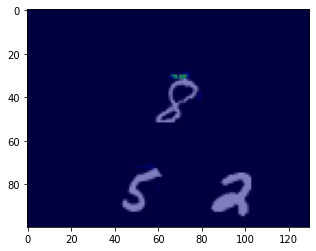

Heatmap for class: 1


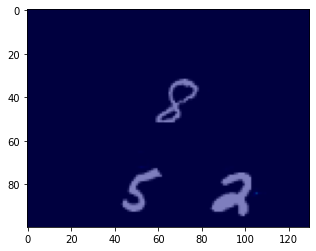

Heatmap for class: 2


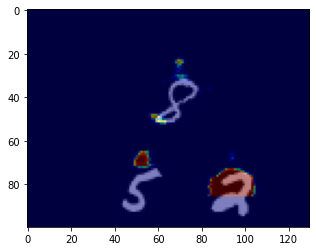

Heatmap for class: 3


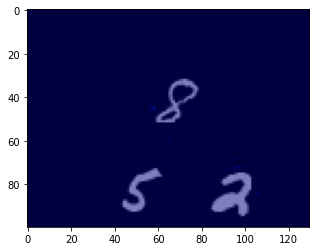

Heatmap for class: 4


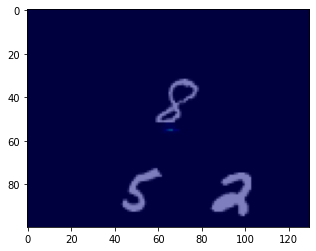

Heatmap for class: 5


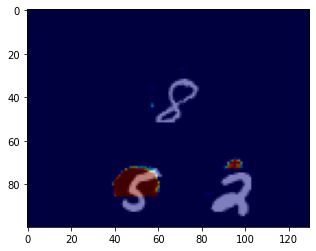

Heatmap for class: 6


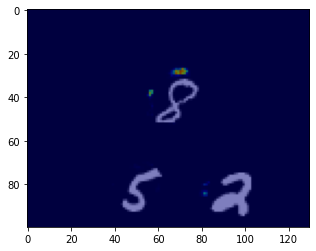

Heatmap for class: 7


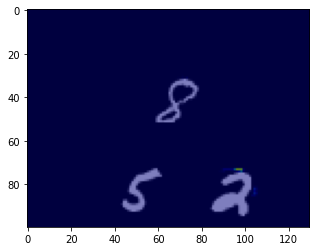

Heatmap for class: 8


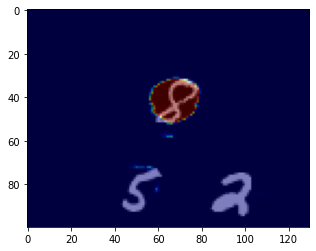

Heatmap for class: 9


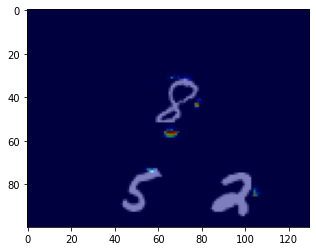

Heatmap for class: 10


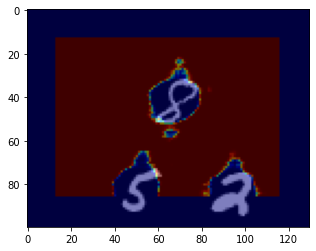

In [17]:
for clss in range(11):
    heatmap = heatmaps[..., clss]
    heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
    print('Heatmap for class:', clss)
    plt.imshow(img_clr*0.5 + heatmap_clr*0.5)    
    plt.show()